# Log-log plot estimator

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# In order to use everything in this notebook will be need some other function that produces some data
# Here will be used `full_data_random_walk()` from 'rwre.py'
from rwre import full_data_random_walk


# taking absolute value of S_n, sorting the samples, calculate mean and median.
def treat_this_data(A):
    absA = np.abs(A)
    sortedAbs = np.sort(absA)
    meanA = absA.mean(1)
    median = np.quantile(absA, 0.5 , 1)
    return (absA,sortedAbs,meanA, median)

# Example  of use
k1=3
k2=6
Numbsimul=10
A = full_data_random_walk(k1,k2,Numbsimul)
print('Raw data')
print(A)
print('\n')
absA, sortedAbs, meanA, median = treat_this_data(A)
print('absolute value of data')
print(absA)
print('\n')
print('sorted absolute value of data')
print(sortedAbs)
print('\n')
print('mean values of each row')
print(meanA)
print('\n')
print('median values of each row')
print(median)

4it [00:00, 19.64it/s]



--- 0.23431611061096191 seconds ---


Raw data
[[-2.  0. -4.  0.  2. -2.  0. -2.  0. -2.]
 [ 2.  4.  4.  4.  8.  0.  2.  0. -4.  0.]
 [ 6.  0.  0.  6.  2. -2.  4.  2.  0.  8.]
 [ 6. 10.  4.  4.  8.  4.  4.  0.  4.  8.]]


absolute value of data
[[ 2.  0.  4.  0.  2.  2.  0.  2.  0.  2.]
 [ 2.  4.  4.  4.  8.  0.  2.  0.  4.  0.]
 [ 6.  0.  0.  6.  2.  2.  4.  2.  0.  8.]
 [ 6. 10.  4.  4.  8.  4.  4.  0.  4.  8.]]


sorted absolute value of data
[[ 0.  0.  0.  0.  2.  2.  2.  2.  2.  4.]
 [ 0.  0.  0.  2.  2.  4.  4.  4.  4.  8.]
 [ 0.  0.  0.  2.  2.  2.  4.  6.  6.  8.]
 [ 0.  4.  4.  4.  4.  4.  6.  8.  8. 10.]]


mean values of each row
[1.4 2.8 3.  5.2]


median values of each row
[2. 3. 2. 4.]


The **confidence interval** is a interval $[a_1,a_2]$ for the quantile $q$, and $a_1$ is defined to be the first element with index less or equal to $q \cdot N - \Phi(\alpha)\sqrt{N}$, and $a_2$ is defined to be the first element with index less or equal to $q \cdot N + \Phi(\alpha)\sqrt{N}$.

- $N$ is the number of simulations done.
- $\alpha$ is the level of confidence.
- $\Phi$ is the inverse of the probability density function of a standard normal, i.e., 

$$\Phi(z) = \int_{-\infty}^z \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}x^2} dx$$

In [ ]:
# calculating the interval of confidence

def confidence_level(q,sortedAbs, alpha=0.01): # it gives a confifence interval centered in quantile q
    numb_columns,numb_rows = sortedAbs.shape
    # numb_columns is the range of simulations done
    # numb_rows is the number of simulations done

    lowerboundindex = [int(np.floor(q*(numb_rows - np.sqrt(numb_rows)*norm.isf(alpha)))) for i in range(numb_columns)]
    upperboundindex = [int(np.ceil(q*(numb_rows + np.sqrt(numb_rows)*norm.isf(alpha)))) for i in range(numb_columns)]
    
    lowerboundheight = sortedAbs[np.arange(numb_columns),lowerboundindex]
    upperboundheight = sortedAbs[np.arange(numb_columns),upperboundindex]

    quantile_q = sortedAbs[np.arange(numb_columns), int( numb_rows*q ) ]
    
    errorbar = [np.abs(lowerboundheight-quantile_q), np.abs(upperboundheight-quantile_q)]
    return errorbar

The following function performs a linear regression of `dom` by `out`

In [8]:
def linear_regression(dom,out,q=None,errorbar=None):
    poly_coef = np.polyfit(dom, out, 1)
    poly_out = [poly_coef[1] + poly_coef[0]*x for x in dom]

    # print the results in a graphic
    if q is not None and errorbar is not None: # when quantile and errorbar are given it's possibleto calulate an errorbar
        plt.plot(dom, poly_out,label='y={:.3}x+{:.2}, quantile{:.2}'.format(poly_coef[0],poly_coef[1],q))
        plt.errorbar(dom,out,yerr=errorbar, label = 'quantile {:.2}'.format(q),capsize=4, marker = 'o')
    else: 
        plt.plot(dom, poly_out,label='y={:.3}x+{:.2}, mean'.format(poly_coef[0],poly_coef[1]))
    
    return poly_coef # returning the values of linear coeficcients


In [ ]:

def log_log_plot(q,dom, A, alpha=0.01):
    absA, sortedAbs, meanA, median = treat_this_data(A)

    logAbs    = np.log(absA)/np.log(2)
    logquantile = np.quantile(logAbs, q, 1)
    logmean   = np.log(meanA)/np.log(2)
    logmedian = np.log(median)/np.log(2)

    errorbar = confidence_level(q,sortedAbs,alpha)
    errorbar_median = confidence_level(0.5, sortedAbs,alpha)

    quantile_coef = linear_regression(dom,logquantile,q,errorbar)
    median_coef = linear_regression(dom,logmedian,0.5,errorbar_median)
    mean_coef = linear_regression(dom,logmean)

    print(" ---- diffusion constant is approximally %s using quantile %s ----" % (quantile_coef[0],q))
    print(" ---- diffusion constant is approximally %s median ----" % (median_coef[0]))
    print(" ---- diffusion constant is approximally %s mean ----" % (mean_coef[0]))
    
    plt.legend(fontsize=12)
    plt.show()  

5it [00:07,  1.43s/it]
/tmp/ipykernel_5445/4246443390.py:5: RuntimeWarning: divide by zero encountered in log
  logAbs    = np.log(absA)/np.log(2)




--- 7.144580364227295 seconds ---


 ---- diffusion constant is approximally 0.4796741238531865 using quantile 0.55 ----
 ---- diffusion constant is approximally 0.3614709844115206 median ----
 ---- diffusion constant is approximally 0.5726725221928409 mean ----


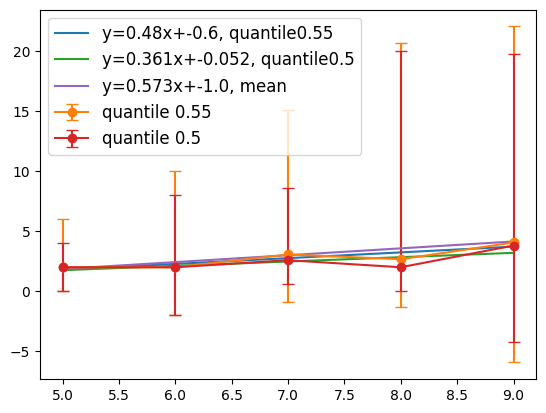

In [ ]:

# Example of use
k1 = 5
k2 = 9
Numbsimul = 25
A = full_data_random_walk(k1,k2, Numbsimul)

q = 0.55
dom = np.arange(k1,k2+1)
log_log_plot(q,dom,A)